# Plant Growth Prediction and Classification

### Goal
The goal of this project is to analyze how well plants can meet their growth milestones based on variables such as light, soil type, water, fertilizer, temperature, and humidity. Four types of classification models (KNN, Decision Tree, Logistic Regression, and SVC) will be trained and fitted on the growth variable data to predict if a plant will successfully reach maturity. Furthermore, we can use permutation importance to analyze each feature and determine the optimal parameters to increase yield.

### Data Problem
We will train, optimize, and cross-validate four binary classification models to predict if the growth condition provided to the plant is sufficient for its maturity.

### Expected Result
The expectation of this study is a predictive model that can accurately determine if the plant will meet its growth milestone based on the environmental factors provided

### Data
This dataset comes from Kaggle: https://www.kaggle.com/datasets/gorororororo23/plant-growth-data-classification/data

The following column descriptions are taken from the dataset provider:
- Soil_Type: The type or composition of soil in which the plants are grown.
- Sunlight_Hours: The duration or intensity of sunlight exposure received by the plants.
- Water_Frequency: How often the plants are watered, indicating the watering schedule.
- Fertilizer_Type: The type of fertilizer used for nourishing the plants.
- Temperature: The ambient temperature conditions under which the plants are grown.
- Humidity: The level of moisture or humidity in the environment surrounding the plants.
- Growth_Milestone: Descriptions or markers indicating stages or significant events in the growth process of the plants.

## Setup
#### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, train_test_split, HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

#### Import Data

In [2]:
data = pd.read_csv('plant_growth_data.csv')

## Data Understanding and Cleaning

Taking a quick look at our data:

In [3]:
data.head()

,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Soil_Type         193 non-null    object 
 1   Sunlight_Hours    193 non-null    float64
 2   Water_Frequency   193 non-null    object 
 3   Fertilizer_Type   193 non-null    object 
 4   Temperature       193 non-null    float64
 5   Humidity          193 non-null    float64
 6   Growth_Milestone  193 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 10.7+ KB


In [5]:
data.isna().sum()

Soil_Type           0
Sunlight_Hours      0
Water_Frequency     0
Fertilizer_Type     0
Temperature         0
Humidity            0
Growth_Milestone    0
dtype: int64

## Exploratory Data Analysis

### Feature Analysis

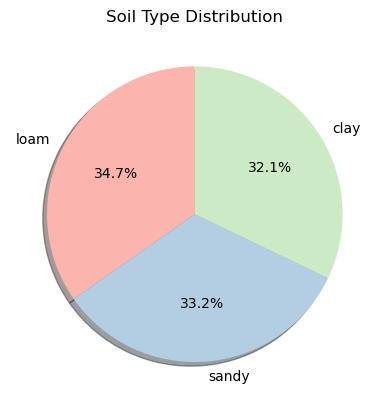

In [6]:
fig, ax = plt.subplots()
ax.pie(data['Soil_Type'].value_counts(),
       labels = data['Soil_Type'].unique(),
       autopct='%1.1f%%',
       colors=plt.get_cmap('Pastel1').colors,
       shadow = True,
       startangle=90)
ax.set_title('Soil Type Distribution')
plt.show()

Text(0.5, 0, 'Sunlight')

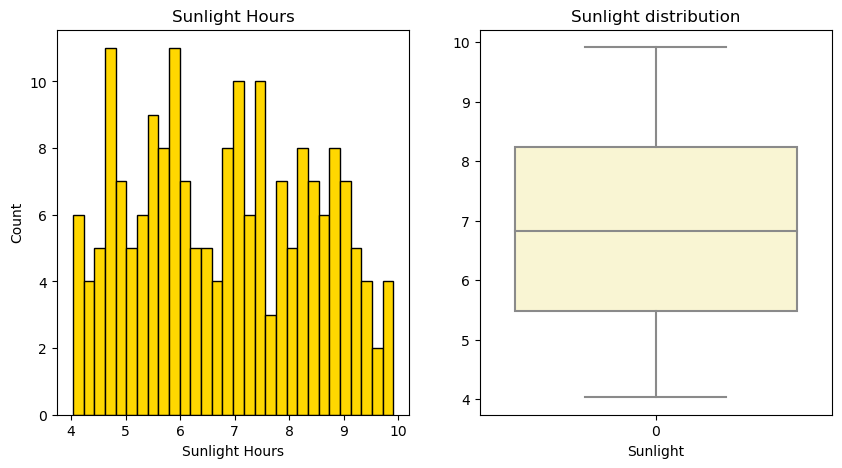

In [7]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(data['Sunlight_Hours'],
         edgecolor='black',
         color = 'gold',
         bins = 30)
plt.title('Sunlight Hours')
plt.xlabel('Sunlight Hours')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(data['Sunlight_Hours'], color='lemonchiffon')
plt.title('Sunlight distribution')
plt.xlabel('Sunlight')


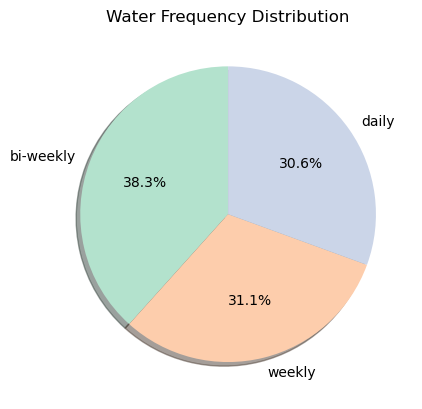

In [8]:
fig, ax = plt.subplots()
ax.pie(data['Water_Frequency'].value_counts(),
       labels = data['Water_Frequency'].unique(),
       autopct='%1.1f%%',
       colors=plt.get_cmap('Pastel2').colors,
       shadow = True,
       startangle=90)
ax.set_title('Water Frequency Distribution')
plt.show()

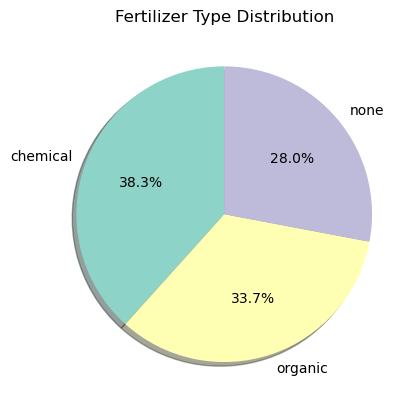

In [9]:
fig, ax = plt.subplots()
ax.pie(data['Fertilizer_Type'].value_counts(),
       labels = data['Fertilizer_Type'].unique(),
       autopct='%1.1f%%',
       colors=plt.get_cmap('Set3').colors,
       shadow = True,
       startangle=90)
ax.set_title('Fertilizer Type Distribution')
plt.show()

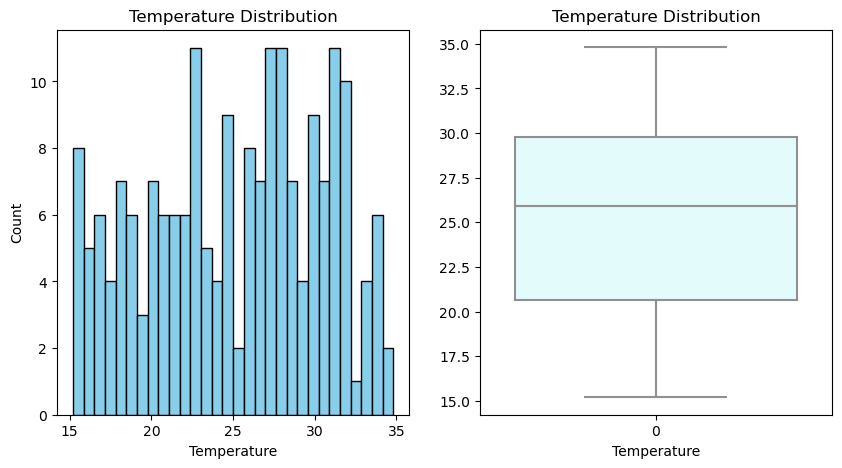

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(data['Temperature'],
         edgecolor='black',
         color = 'skyblue',
         bins = 30)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(data['Temperature'], color='lightcyan')
plt.title('Temperature Distribution')
plt.xlabel('Temperature')

plt.show()

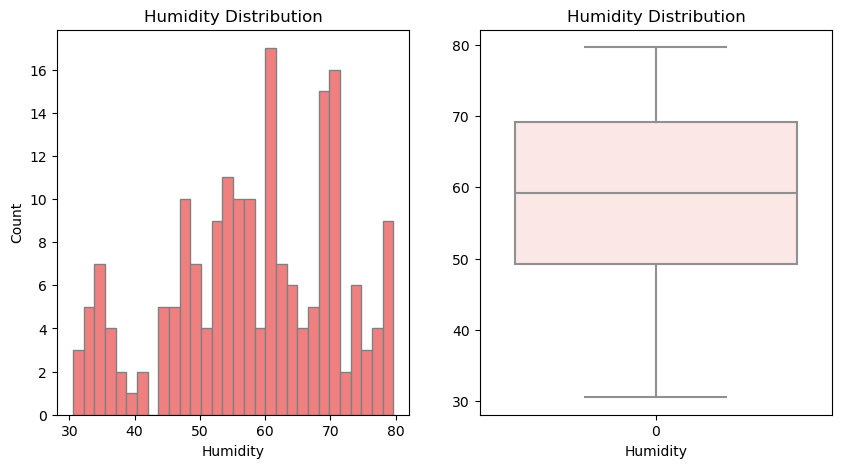

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(data['Humidity'],
         edgecolor='grey',
         color = 'lightcoral',
         bins = 30)
plt.title('Humidity Distribution')
plt.xlabel('Humidity')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.boxplot(data['Humidity'], color='mistyrose')
plt.title('Humidity Distribution')
plt.xlabel('Humidity')

plt.show()

### Summary of Data Distribution
- Categorical features are well balanced with each unique type accounting for roughly the same percentage of the whole
- Numerical features do not contain outliers and are randomly distributed. Statistical mean lies approximately at the center of range.

### Target Variable Analysis
- We can see from the chart below that we have a very balanced dataset

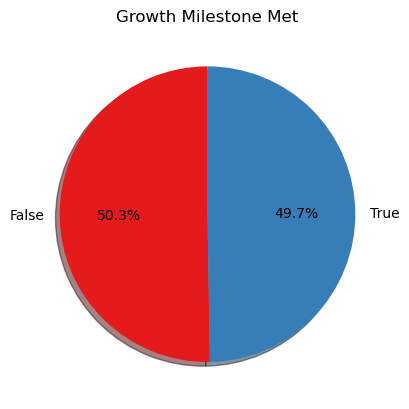

In [12]:
fig, ax = plt.subplots()
ax.pie(data['Growth_Milestone'].value_counts(),
       labels = [False, True],
       autopct='%1.1f%%',
       colors=plt.get_cmap('Set1').colors,
       shadow = True,
       startangle=90)
ax.set_title('Growth Milestone Met')
plt.show()

## Data Cleaning and Preprocessing

In [13]:
X = data.drop('Growth_Milestone', axis=1)
y = data['Growth_Milestone']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle = True)

In [15]:
# Transformer to be used in pipeline
te = make_column_transformer((TargetEncoder(target_type = 'binary'), 
                              make_column_selector(dtype_include=object)),
                              remainder = StandardScaler(),
                              verbose_feature_names_out = False)

## Modeling

### Baseline model
- We will use a simple Logistic Regression classifier with default parameters as our baseline model
- The goal is to improve upon this baseline classifier such that our performance metrics (accuracy, precision, recall) is maximized and computation time is minimized

In [16]:
baseline_pipe = Pipeline([('te', te),
                    ('lr', LogisticRegression())])

In [17]:
tic = time.time()
baseline_pipe.fit(X_train, y_train)
toc = time.time() - tic
train_acc = accuracy_score(y_train, baseline_pipe.predict(X_train))
test_acc = accuracy_score(y_test, baseline_pipe.predict(X_test))
train_prec = precision_score(y_train, baseline_pipe.predict(X_train))
test_prec = precision_score(y_test, baseline_pipe.predict(X_test))
train_rec = recall_score(y_train, baseline_pipe.predict(X_train))
test_rec = recall_score(y_test, baseline_pipe.predict(X_test))
scores_dict = {'Set': ['Train', 'Test'],
               'Accuracy': [train_acc, test_acc],
               'Precision': [train_prec, test_prec],
               'Recall': [train_rec, test_rec]}
pd.DataFrame.from_dict(scores_dict)

,Set,Accuracy,Precision,Recall
0,Train,0.642857,0.641791,0.581081
1,Test,0.538462,0.600000,0.545455


In [18]:
def score_df(pipe, X_train, y_train, info):
    tic = time.time()
    pipe.fit(X_train, y_train)
    toc = time.time() - tic
    train_acc = accuracy_score(y_train, pipe.predict(X_train))
    test_acc = accuracy_score(y_test, pipe.predict(X_test))
    train_prec = precision_score(y_train, pipe.predict(X_train))
    test_prec = precision_score(y_test, pipe.predict(X_test))
    train_rec = recall_score(y_train, pipe.predict(X_train))
    test_rec = recall_score(y_test, pipe.predict(X_test))
    scores_dict = {'Set': ['Train', 'Test'],
                   'Accuracy': [train_acc, test_acc],
                   'Precision': [train_prec, test_prec],
                   'Recall': [train_rec, test_rec]}
    if info == 'score':
        return pd.DataFrame.from_dict(scores_dict)
    if info == 'time':
        return toc

### Logistic Regression

In [19]:
lr_params = {'lr__C': [0.01, 0.1, 1, 10, 100],
             'lr__solver': ['liblinear', 'saga']}

In [20]:
lr_pipe = Pipeline([('te', te),
                    ('lr', LogisticRegression(max_iter = 100000))])

In [21]:
lr_grid = GridSearchCV(lr_pipe, lr_params)
lr_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('te',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(target_type='binary'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x12f121390>)],
                                                          verbose_feature_names_out=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=100000))]),
             param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__solver': ['liblinear', 'saga']})

In [22]:
lr_results = score_df(lr_grid.best_estimator_, X_train, y_train, 'score')
lr_time = score_df(lr_grid.best_estimator_, X_train, y_train, 'time')
print(lr_results, '\n', 'Fit time', lr_time)

     Set  Accuracy  Precision    Recall
0  Train  0.662338   0.666667  0.594595
1   Test  0.589744   0.636364  0.636364 
 Fit time 0.018702983856201172


### Decision Tree Classifier

In [23]:
dtree_params = {'dtree__max_depth': [None, 10, 20, 30, 40, 50],
                'dtree__min_samples_split': [2, 4, 6, 8, 10],
                'dtree__min_samples_leaf': [1, 3, 5, 7]}

In [24]:
dtree_pipe = Pipeline([('te', te),
                    ('dtree', DecisionTreeClassifier())])

In [25]:
dtree_grid = GridSearchCV(dtree_pipe, dtree_params)
dtree_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('te',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(target_type='binary'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x12f121390>)],
                                                          verbose_feature_names_out=False)),
                                       ('dtree', DecisionTreeClassifier())]),
             param_grid={'dtree__max_depth': [None, 10, 20, 30, 40, 50],
                         'dtree__min_samples_leaf': [1, 3, 5, 7],
                         'dtree__min_samples_split': [2, 4, 6, 8, 10]})

In [26]:
dtree_results = score_df(dtree_grid.best_estimator_, X_train, y_train, 'score')
dtree_time = score_df(dtree_grid.best_estimator_, X_train, y_train, 'time')
print(dtree_results, '\n', 'Fit time', dtree_time)

     Set  Accuracy  Precision    Recall
0  Train  0.876623   0.910448  0.824324
1   Test  0.641026   0.681818  0.681818 
 Fit time 0.013198137283325195


### K-Neighbors Classifier

In [27]:
knn_params = {'knn__n_neighbors': [2, 4, 6, 8, 10],
              'knn__weights': ['uniform', 'distance']}

In [28]:
knn_pipe = Pipeline([('te', te),
                    ('knn', KNeighborsClassifier())])

In [29]:
knn_grid = GridSearchCV(knn_pipe, knn_params)
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('te',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(target_type='binary'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x12f121390>)],
                                                          verbose_feature_names_out=False)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [2, 4, 6, 8, 10],
                         'knn__weights': ['uniform', 'distance']})

In [30]:
knn_results = score_df(knn_grid.best_estimator_, X_train, y_train, 'score')
knn_time = score_df(knn_grid.best_estimator_, X_train, y_train, 'time')
print(knn_results, '\n', 'Fit time', knn_time)

     Set  Accuracy  Precision    Recall
0  Train  0.681818   0.686567  0.621622
1   Test  0.384615   0.428571  0.272727 
 Fit time 0.01009988784790039


### SVC

In [31]:
svc_params = {'svc__C': [0.01, 0.1, 1, 10, 100],
              'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [32]:
svc_pipe = Pipeline([('te', te),
                    ('svc', SVC())])

In [33]:
svc_grid = GridSearchCV(svc_pipe, svc_params)
svc_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('te',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(target_type='binary'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x12f121390>)],
                                                          verbose_feature_names_out=False)),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.01, 0.1, 1, 10, 100],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [34]:
svc_results = score_df(svc_grid.best_estimator_, X_train, y_train, 'score')
svc_time = score_df(svc_grid.best_estimator_, X_train, y_train, 'time')
print(svc_results, '\n', 'Fit time', svc_time)

     Set  Accuracy  Precision    Recall
0  Train  0.655844   0.666667  0.567568
1   Test  0.512821   0.571429  0.545455 
 Fit time 0.011870861053466797


Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

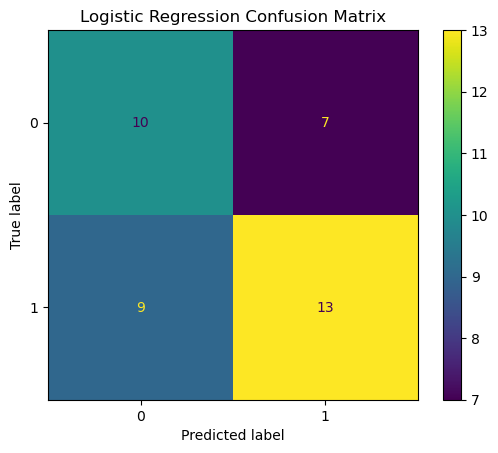

In [35]:
ConfusionMatrixDisplay(confusion_matrix(y_test, lr_grid.best_estimator_.predict(X_test))).plot()
plt.title("Logistic Regression Confusion Matrix")

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

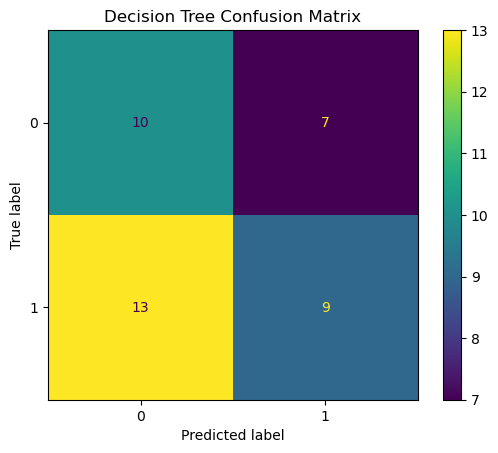

In [36]:
ConfusionMatrixDisplay(confusion_matrix(y_test, dtree_grid.best_estimator_.predict(X_test))).plot()
plt.title("Decision Tree Confusion Matrix")

Text(0.5, 1.0, 'K-Neighbors Confusion Matrix')

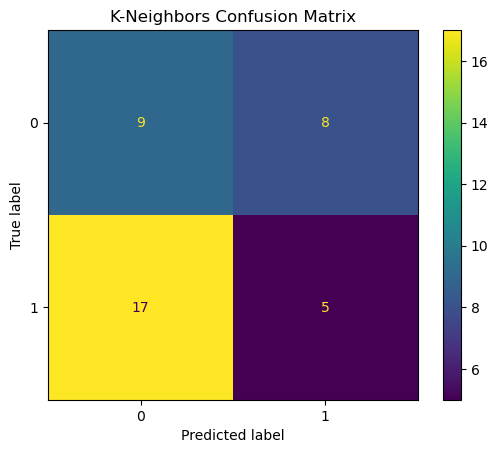

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test, knn_grid.best_estimator_.predict(X_test))).plot()
plt.title("K-Neighbors Confusion Matrix")

Text(0.5, 1.0, 'SVC Confusion Matrix')

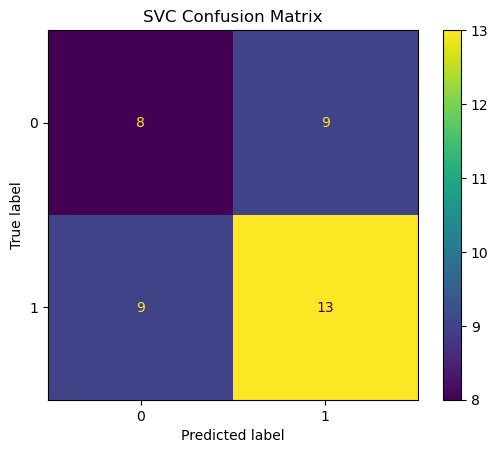

In [38]:
ConfusionMatrixDisplay(confusion_matrix(y_test, svc_grid.best_estimator_.predict(X_test))).plot()
plt.title("SVC Confusion Matrix")

### Feature Importance

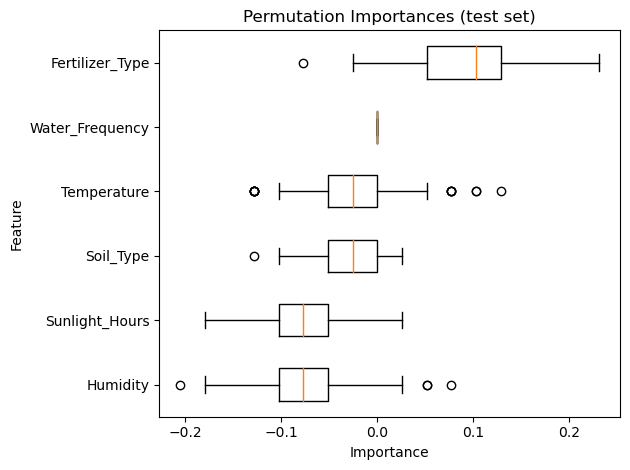

In [39]:
# Permutation Importance using best logistic regression model
perm_imp = permutation_importance(dtree_grid.best_estimator_, X_test, y_test, n_repeats = 100)
sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
fig.tight_layout()
plt.show()

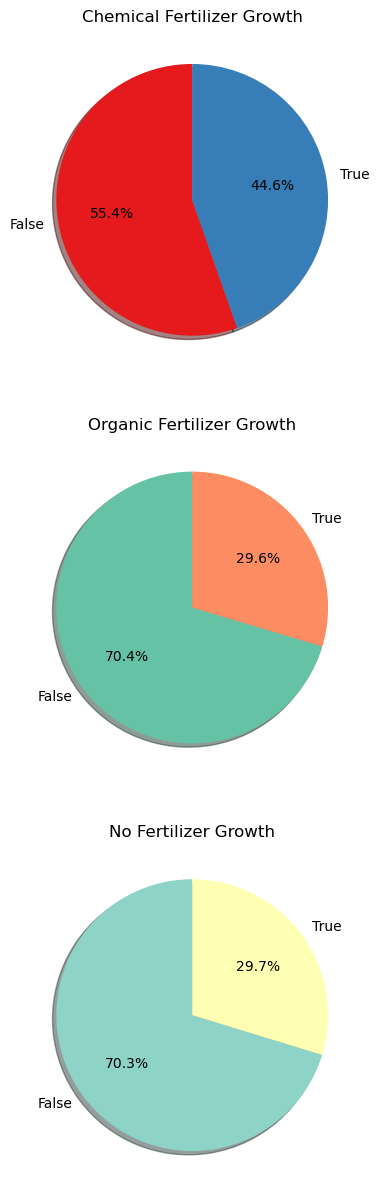

In [40]:
chem_fertilizer = data.query("Fertilizer_Type == 'chemical'")
org_fertilizer = data.query("Fertilizer_Type == 'organic'")
none_fertilizer = data.query("Fertilizer_Type == 'none'")

plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.pie(chem_fertilizer['Growth_Milestone'].value_counts(),
       labels = [False, True],
       autopct='%1.1f%%',
       colors=plt.get_cmap('Set1').colors,
       shadow = True,
       startangle=90)
plt.title('Chemical Fertilizer Growth')

plt.subplot(3,1,2)
plt.pie(org_fertilizer['Growth_Milestone'].value_counts(),
       labels = [False, True],
       autopct='%1.1f%%',
       colors=plt.get_cmap('Set2').colors,
       shadow = True,
       startangle=90)
plt.title('Organic Fertilizer Growth')

plt.subplot(3,1,3)
plt.pie(none_fertilizer['Growth_Milestone'].value_counts(),
       labels = [False, True],
       autopct='%1.1f%%',
       colors=plt.get_cmap('Set3').colors,
       shadow = True,
       startangle=90)
plt.title('No Fertilizer Growth')
plt.show()

- From the above charts we can see that the percentage of plants that met their growth metric and was fed chemical ferilizer was about 1.5x that of organic fertilizer and no fertilizer

### Decision Tree with Fertilizer Feature Only

In [43]:
trunc_X = data[['Fertilizer_Type']]
trunc_y = data['Growth_Milestone']
trunc_X_train, trunc_X_test, trunc_y_train, trunc_y_test = train_test_split(trunc_X, trunc_y, test_size=0.2, random_state = 42, shuffle = True)

In [45]:
dtree_grid.fit(trunc_X_train, trunc_y_train)
dtree_results = score_df(dtree_grid.best_estimator_, trunc_X_train, trunc_y_train, 'score')
dtree_time = score_df(dtree_grid.best_estimator_, trunc_X_train, trunc_y_train, 'time')
print(dtree_results, '\n', 'Fit time', dtree_time)

     Set  Accuracy  Precision    Recall
0  Train  0.642857   0.604396  0.743243
1   Test  0.692308   0.678571  0.863636 
 Fit time 0.00503087043762207


In [46]:
dtree_grid.best_estimator_

Pipeline(steps=[('te',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('targetencoder',
                                                  TargetEncoder(target_type='binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12efce410>)],
                                   verbose_feature_names_out=False)),
                ('dtree',
                 DecisionTreeClassifier(max_depth=20, min_samples_leaf=3))])

## Results

- Decision Tree Classifier scored the highest for all metrics (accuracy, precision, recall)
- After performing permutation importance on the features, we find that 'fertilizer type' seemed to be the only variable that impacted whether or not a plant met its growth milestone
- We then used 'fertilizer type' as the only feature to train our Decision Tree Classifier on, and found an increase in accuracy, precision, and recall
- The best classifier model was determined to be DecisionTreeClassifier with max_depth = 20 and min_samples_leaf = 3, which yielded an accuracy score of 0.692308, a precision score of 0.678571, and a recall score of 0.863636
- Fertilizer type is crucial for determining if a plant meets its growth milestone, as a plant fed with chemical fertilizer was 1.5x more likely succeed compared to plants fed with organic fertilizer and no fertilizer